In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import csv
import pandas as pd

In [17]:
rppa_M = os.path.join('../dataset/tumour_microenv_results_2020-9/rppa/NCP','M_rppa_ncp.xlsx')
gcp_M = os.path.join('../dataset/tumour_microenv_results_2020-9-3/gcp/NCP','M_gcp_ncp.xlsx')

rppa_M1 = pd.read_excel(rppa_M, sheet_name='M1_AB').set_index('Protein')
gcp_M1 = pd.read_excel(gcp_M, sheet_name='M1_AB').set_index('Histone')
print('rppa_M1', rppa_M1.shape)
print('gcp_M1', gcp_M1.shape)

rppa_M1 (274, 6)
gcp_M1 (58, 6)


In [18]:
rppa_M1_mat = rppa_M1.values.T
gcp_M1_mat = gcp_M1.values.T
print('rppa_M1_mat', rppa_M1_mat.shape)
print('gcp_M1_mat', gcp_M1_mat.shape)

rppa_M1_mat (6, 274)
gcp_M1_mat (6, 58)


In [19]:
# to test the PLSR model

from sklearn.cross_decomposition import PLSRegression
# X = [[0., 0., 1., 2,2], 
#      [1.,0.,0.,3,1], 
#      [2.,2.,2.,1,2], 
#      [2.,5.,4.,1,4]]

# Y = [[0.1, -0.2, 1.,2.], 
#      [0.9, 1.1, 2.,4.], 
#      [6.2, 5.9, 1.,1.], 
#      [11.9, 12.3, 1.,2.]]
pls2 = PLSRegression(n_components=5)
pls2.fit(rppa_M1_mat, gcp_M1_mat)
print(pls2.coef_.shape)
# pls2.coef_

(274, 58)


E:\softwareInstall\Anaconda3\envs\localpython\lib\site-packages\sklearn\cross_decomposition\_pls.py:351: UserWarning: X scores are null at iteration 2
  warnings.warn('X scores are null at iteration %s' % k)


In [20]:
coefficient_mat = pd.DataFrame(data=pls2.coef_, index=rppa_M1.index, columns=gcp_M1.index)
coefficient_mat_abs = np.absolute(coefficient_mat)
coefficient_mat_mean = coefficient_mat_abs.mean(axis=1)

coefficient_mat_abs['Avg'] = coefficient_mat_mean.values
writer = pd.ExcelWriter('../dataset/tumour_microenv_results_2020-9/coef_histone_by_protein_ncp.xlsx')

coefficient_mat.to_excel(writer, 'original')
coefficient_mat_abs.to_excel(writer, 'absolute_processed')
writer.save()

In [21]:
coefficient_mat_mean.to_frame()

,0
Protein,
ACACApS79,0.000803
ACTB,0.000623
ADAR,0.003919
AIM1,0.001340
AKT,0.000693
...,...
ULK1pS757,0.003062
WEE1pS642,0.003752
WWTR1,0.003043


mean:0.0021458266298524675, std:0.0014750748605604142


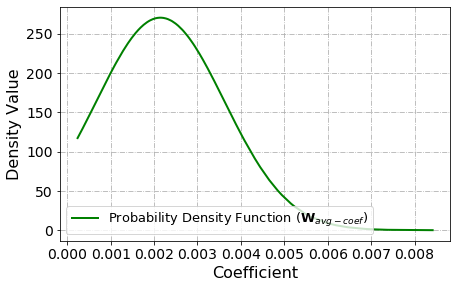

In [22]:
from scipy.stats import norm
fig = plt.figure(figsize=(7, 4.3))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)

ph_cor_avg = np.array(coefficient_mat_mean.values)
ph_cor_avg.sort()
mean, std = norm.fit(ph_cor_avg)
print('mean:{}, std:{}'.format(mean, std))

fitted_pdf = norm.pdf(ph_cor_avg, loc=mean, scale=std)
linestyle = {"linestyle":"-", "linewidth":2, "markeredgewidth":2, "elinewidth":2, "capsize":5}
plt.errorbar(ph_cor_avg, fitted_pdf, color="green", **linestyle, fmt='-')
plt.xlabel("Coefficient", fontsize=16)
plt.ylabel("Density Value", fontsize=16)
plt.legend(['Probability Density Function ($\mathbf{W}_{avg-coef}$)'], fontsize=13)
plt.grid(linestyle='-.')


intense_density = np.concatenate([ph_cor_avg, fitted_pdf]).reshape(2, ph_cor_avg.shape[0]).transpose([1,0])
intense_density_mat = pd.DataFrame(data=intense_density, columns=['Intensity','Dnesity'])
intense_density_mat.loc[-1] = [mean, std]
intense_density_mat.index = intense_density_mat.index + 1
intense_density_mat = intense_density_mat.sort_index()
intense_density_mat.rename(index = {0: "mean/std"}, inplace = True)
intense_density_mat.to_excel(writer, "M_coef_Intensity_dist")
writer.save()

In [25]:
coe_mean_frame

,Itensity
Protein,
ACACApS79,0.000803
ACTB,0.000623
ADAR,0.003919
AIM1,0.001340
AKT,0.000693
...,...
ULK1pS757,0.003062
WEE1pS642,0.003752
WWTR1,0.003043


In [24]:
M_mean = 0.0021747288081365177

#------------------center_MeanElbow-----------------
M_cutoff = 0.0037611649040682578 - M_mean

coe_mean_frame = coefficient_mat_mean.to_frame()
coe_mean_frame.columns = ['Itensity']
rppa_gcp_stack_sorted = coe_mean_frame[~((coe_mean_frame.values-M_mean < M_cutoff))]#.sort_values(by='Itensity',ascending=False)
rppa_gcp_stack_sorted.to_excel(writer, 'M_coef_center_MeanElbow')
writer.save()


#------------------elbow-----------------
M_cutoff = 0.005347601 - M_mean

coe_mean_frame = coefficient_mat_mean.to_frame()
coe_mean_frame.columns = ['Itensity']
rppa_gcp_stack_sorted_elbow = coe_mean_frame[~((coe_mean_frame.values-M_mean < M_cutoff))]#.sort_values(by='Itensity',ascending=False)
rppa_gcp_stack_sorted_elbow.to_excel(writer, 'M_coef_Elbow')
writer.save()

#------------------Asymptotic-----------------
M_cutoff = 0.007005124 - M_mean

coe_mean_frame = coefficient_mat_mean.to_frame()
coe_mean_frame.columns = ['Itensity']
rppa_gcp_stack_sorted = coe_mean_frame[~((coe_mean_frame.values-M_mean < M_cutoff))]#.sort_values(by='Itensity',ascending=False)
rppa_gcp_stack_sorted.to_excel(writer, 'M_coef_Asymptotic')
writer.save()


In [26]:
coefficient_mat_selected

Histone,H3K9me2S10ph1K14ac0,H3K9me3S10ph1K14ac0,H3K18ub1K23ac0,H4(20to23)K20me0,H3K4ac1
Protein,,,,,
ANXA7,-0.005644,-0.005215,-0.002138,-0.000878,0.024353
BID,-0.005820,-0.005381,-0.002214,-0.000933,0.024944
COL6A1,-0.007669,-0.007135,-0.003015,-0.001514,0.031123
EGFRpY1173,-0.008095,-0.007539,-0.003200,-0.001650,0.032535
EIF4EBP1,-0.006919,-0.006423,-0.002689,-0.001277,0.028623
ESR1pS118,-0.006900,-0.006405,-0.002681,-0.001271,0.028559
HIF1A,-0.006320,-0.005855,-0.002430,-0.001089,0.026621
MCL1,-0.009477,-0.008851,-0.003801,-0.002094,0.037088
PRKCDpS664,-0.007444,-0.006921,-0.002917,-0.001443,0.030372


In [27]:
seleted_proteins = rppa_gcp_stack_sorted_elbow.index
selected_histones = ['H3K9me2S10ph1K14ac0 ', 'H3K9me3S10ph1K14ac0 ', 'H3K18ub1K23ac0 ', 
                     'H4(20to23)K20me0', 'H3K4ac1 ']

coefficient_mat_ = coefficient_mat[coefficient_mat.index.isin(seleted_proteins)]
coefficient_mat_selected = coefficient_mat_[selected_histones]


(coefficient_mat_selected*100).to_excel(writer, "selected_protein_histone")
writer.save()

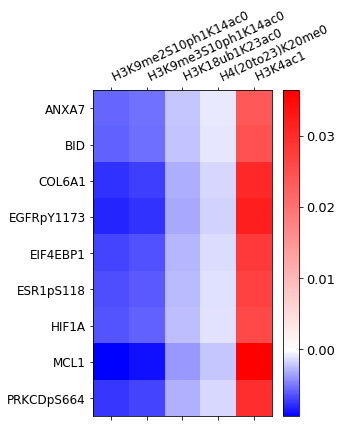

In [28]:
from matplotlib import colors

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
plt.set_cmap('bwr')
norm = colors.DivergingNorm(vcenter=0)
aa = ax.matshow(coefficient_mat_selected.values,norm =norm)
ax.set_aspect('auto')

ax.set_yticks(np.arange(len(seleted_proteins)))
ax.set_yticklabels(coefficient_mat_selected.index.tolist(), fontsize=12)
# ax.set_yticks(['1','2'])
ax.set_xticklabels(coefficient_mat_selected.columns.insert(0,''), rotation=25, fontsize=12, ha="left")
# ax.set_title('$\mathbf{W}_{coef}$', y=-0.1, fontsize=16)
plt.rc('ytick',labelsize=13)
fig.colorbar(aa)

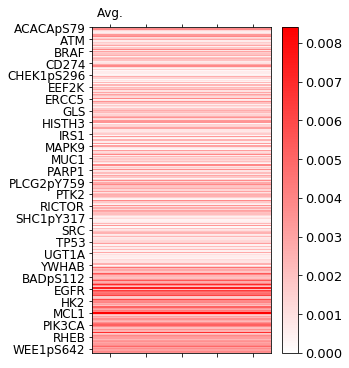

In [29]:
import matplotlib.ticker as plticker
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
plt.set_cmap('bwr')
norm = colors.DivergingNorm(vcenter=0)
aa = ax.matshow(np.expand_dims(coefficient_mat_mean.values, axis=0).T,norm =norm)
ax.set_aspect('auto')

ax.set_yticks(np.arange(len(coefficient_mat_mean.index)))
loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
show_protein_names = coefficient_mat_mean.index[range(0, len(coefficient_mat_mean.index), 10)].insert(0,'')
ax.set_xticklabels(['','Avg.'], fontsize=12)
ax.set_yticklabels(show_protein_names, fontsize=12)

fig.colorbar(aa)

In [1]:
# rppa_M2_per_ligands = pd.read_excel(rppa_M, sheet_name='M2_AC_per_ligands').set_index('Unnamed: 0')
# m2_vs = rppa_M2_per_ligands[rppa_M2_per_ligands.index.isin(seleted_proteins)].apply(pd.to_numeric, errors='ignore').values

# fig = plt.figure(figsize=(18,16))
# ax = fig.add_subplot(111)
# plt.set_cmap('bwr')
# norm = colors.DivergingNorm(vcenter=0)
# y = np.array([0,3,8,10,12,16,21,24,29,32])
# xx,yy = np.meshgrid(np.arange(25),y)

# aa = ax.pcolormesh(xx,yy,m2_vs,norm =norm, edgecolors='k')
# ax.set_aspect('auto')

# ax.set_ylim(y.min(),y.max())

# # set the yticks + labels
# ax.set_yticks(y[1:] - np.diff(y) / 2)
# ax.set_yticklabels(coefficient_mat_selected.index.tolist(), fontsize=15)

# # ax.set_yticks(np.arange(len(seleted_proteins)))
# # ax.set_yticklabels(coefficient_mat_selected.index.tolist(), fontsize=12)
# # # ax.set_yticks(['1','2'])
# # ax.set_xticklabels(coefficient_mat_selected.columns.insert(0,''), rotation=25, fontsize=12, ha="left")
# # ax.set_title('$\mathbf{M}_{coef}$', y=-0.1, fontsize=16)
# ax.set_xticks(np.arange(24)+0.5)
# labs = ['4_h','EGF\n\n8_h','24_h','48_h',
#        '4_h','HGF\n\n8_h','24_h','48_h',
#        '4_h','OSM\n\n8_h','24_h','48_h',
#         '4_h','BMP2\n\n8_h','24_h','48_h',
#        '4_h','IFNG\n\n8_h','24_h','48_h',
#        '4_h','TGFB\n\n8_h','24_h','48_h']
# ax.set_xticklabels(labs, fontsize=15)

# # tick_labels = ['4','8\n\nSun', '24','48']*6
# # ax.set_xticklabels(tick_labels)

# plt.figure(figsize=(15, 8))
# ax.xaxis.tick_top()
# cb=fig.colorbar(aa,orientation="horizontal", pad=0.03)
# cb.ax.tick_params(labelsize=15)


In [32]:
ylab_list = ['ANXA7', 'BID', 'COL6A1', 'EGFR', 'EIF4EBP1', 'ESR1',
       'HIF1A', 'MCL1', 'PRKCD']
coefficient_mat_selected.index

Index(['ANXA7', 'BID', 'COL6A1', 'EGFRpY1173', 'EIF4EBP1', 'ESR1pS118',
       'HIF1A', 'MCL1', 'PRKCDpS664'],
      dtype='object', name='Protein')

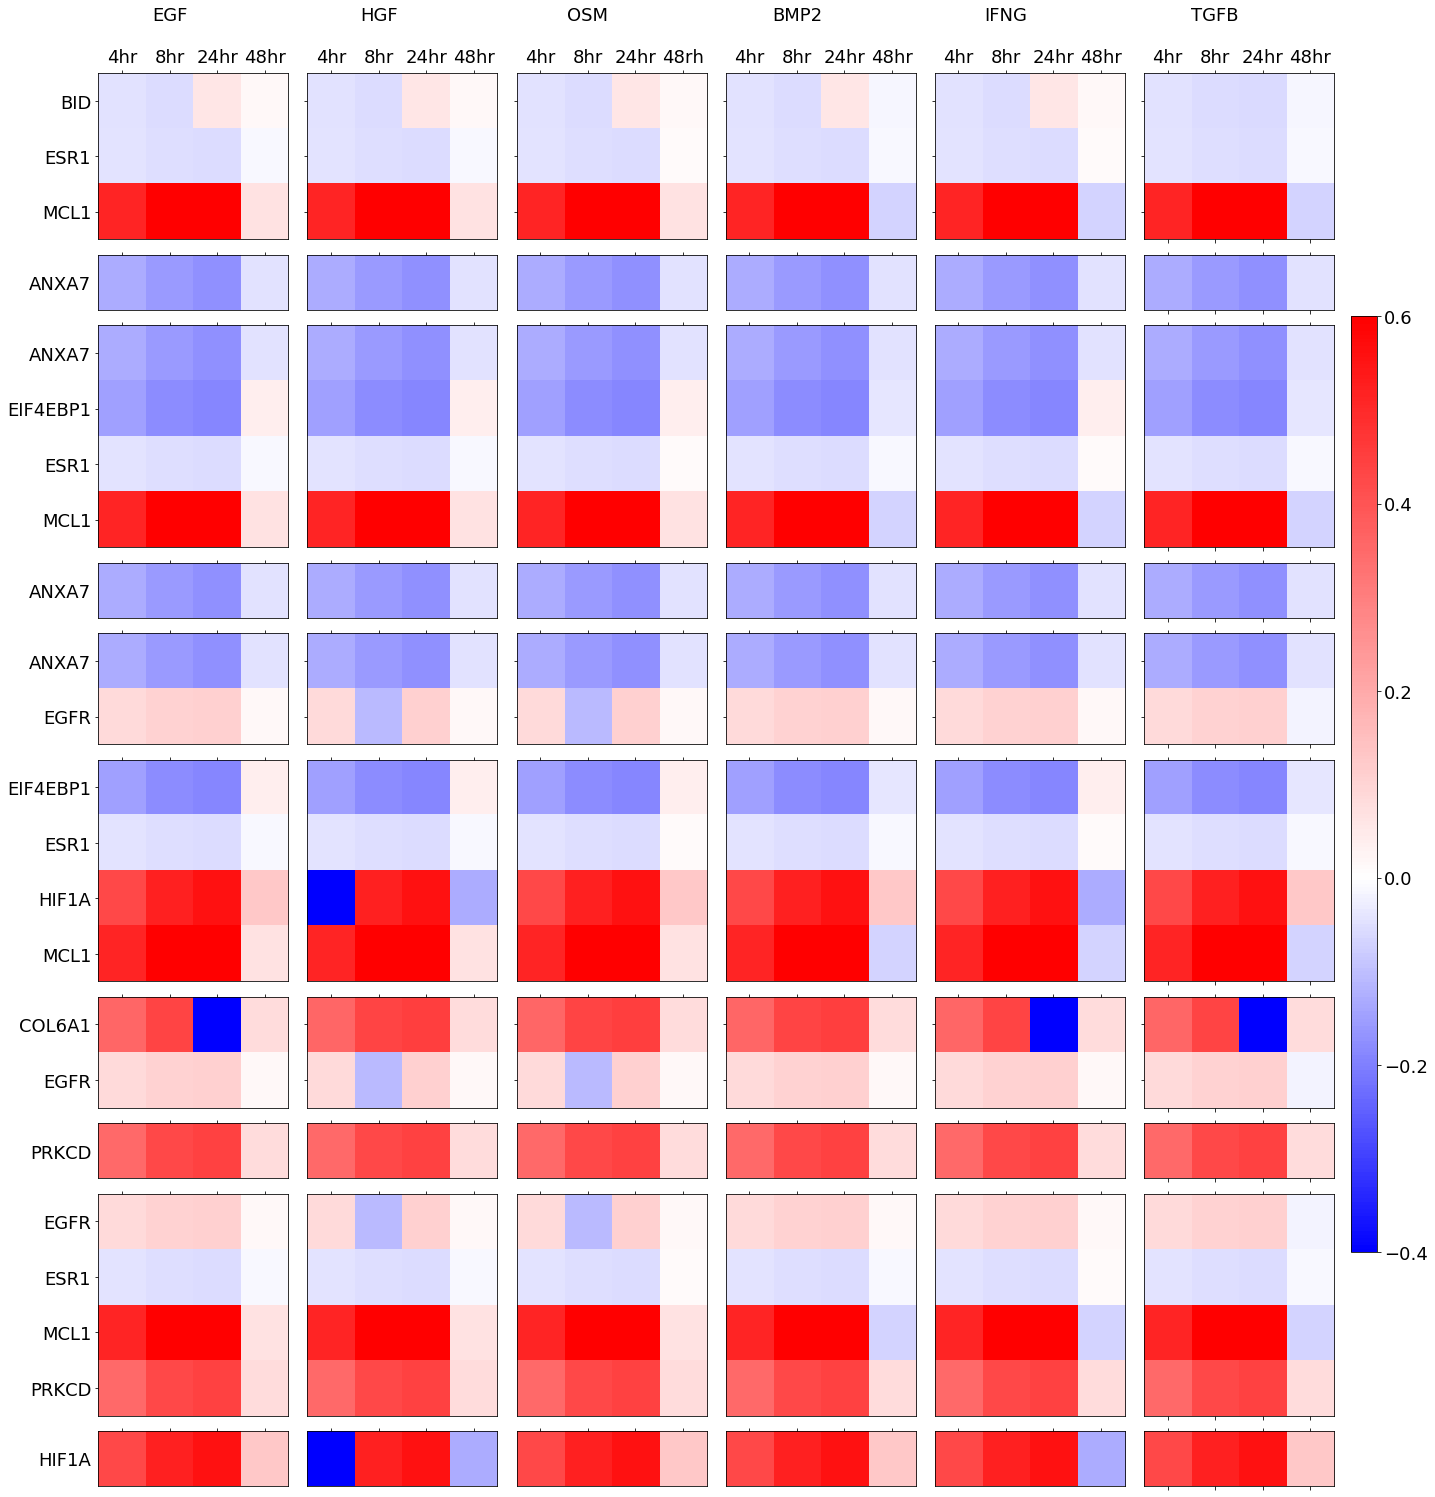

In [33]:
rppa_M2_per_ligands = pd.read_excel(rppa_M, sheet_name='M2_AC_per_ligands').set_index('Unnamed: 0')
m2_vs = rppa_M2_per_ligands[rppa_M2_per_ligands.index.isin(seleted_proteins)].apply(pd.to_numeric, errors='ignore').values


labs = [['','4hr','EGF\n\n8hr','24hr','48hr'],
       ['','4hr','HGF\n\n8hr','24hr','48hr'],
       ['','4hr','OSM\n\n8hr','24hr','48rh'],
       ['','4hr','BMP2\n\n8hr','24hr','48hr'],
       ['','4hr','IFNG\n\n8hr','24hr','48hr'],
       ['','4hr','TGFB\n\n8hr','24hr','48hr']]
# ax.set_xticklabels(labs, fontsize=15)

pathways = {'Apoptosis':[1,5,7],
            'Cell adhesion':[0],
            'Cell cycle':[0,4,5,7],
            'Cell migration':[0],
            'Cell motility':[0,3],
            'Differentiation':[4,5,6,7],
            'Focal adhesion':[2,3],
            'Inflammation':[8],
            'Proliferation':[3,5,7,8],
            'Regulation of autophagy':[6]}

# fig = plt.figure(figsize=(20,36))
layer = len(pathways)
fig, axes = plt.subplots(layer,6,figsize=(24,26),sharey=False,sharex=False,gridspec_kw = {'height_ratios':[3,1,4,1,2,4,2,1,4,1]})

# cb=fig.colorbar(aa, pad=0.03)
# cb.set_clim(-0.4, 0.6)
# cb.ax.tick_params(labelsize=15)


layer = len(pathways)
i = 0
for k in pathways.keys():
    
    protein_ids = pathways[k]
    
    # plt.subplot(1, 4, 1)
#     ax = fig.add_subplot(layer,6,i*6+1)
    ax = axes[i][0]
    plt.set_cmap('bwr')
    norm = colors.DivergingNorm(vcenter=0)
    aa = ax.matshow(m2_vs[protein_ids,0:4],norm =norm)
    ax.set_aspect('auto')
    ax.xaxis.tick_top()
    ylabs = ['']+list(np.array(ylab_list)[protein_ids])
#     ylabs = ['']+list(np.array(coefficient_mat_selected.index.to_list())[protein_ids])
    if len(ylabs) == 2:
        ylabs = ['',''] + ylabs +['']
        ax.tick_params(direction='out', axis ='y', width=0)
    ax.set_yticklabels(ylabs, fontsize=18)
    ax.set_xticklabels([])
    aa.set_clim(-0.4, 0.6)
    if i == 0:
        ax.xaxis.tick_top()
        ax.set_xticklabels(labs[0], fontsize=18)

#     ax = fig.add_subplot(layer,6,i*6+2)
    ax = axes[i][1]
    plt.set_cmap('bwr')
    norm = colors.DivergingNorm(vcenter=0)
    aa = ax.matshow(m2_vs[protein_ids,4:8],norm =norm)
    ax.set_aspect('auto')
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    aa.set_clim(-0.4, 0.6)
    if i == 0:
        ax.set_xticklabels(labs[1], fontsize=18)
    if len(ylabs) == 5:
        ax.tick_params(direction='out', axis ='y', width=0)
    ax.set_yticklabels([])

#     ax = fig.add_subplot(layer,6,i*6+3)
    ax = axes[i][2]
    plt.set_cmap('bwr')
    norm = colors.DivergingNorm(vcenter=0)
    aa = ax.matshow(m2_vs[protein_ids,8:12],norm =norm)
    ax.set_aspect('auto')
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    aa.set_clim(-0.4, 0.6)
    if len(ylabs) == 5:
        ax.tick_params(direction='out', axis ='y', width=0)
    if i == 0:
        ax.set_xticklabels(labs[2], fontsize=18)
    ax.set_yticklabels([])

#     ax = fig.add_subplot(layer,6,i*6+4)
    ax = axes[i][3]
    plt.set_cmap('bwr')
    norm = colors.DivergingNorm(vcenter=0)
    aa = ax.matshow(m2_vs[protein_ids,12:16],norm =norm)
    ax.set_aspect('auto')
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    aa.set_clim(-0.4, 0.6)
    if len(ylabs) == 5:
        ax.tick_params(direction='out', axis ='y', width=0)
    if i == 0:
        ax.set_xticklabels(labs[3], fontsize=18)
    ax.set_yticklabels([])

#     ax = fig.add_subplot(layer,6,i*6+5)
    ax = axes[i][4]
    plt.set_cmap('bwr')
    norm = colors.DivergingNorm(vcenter=0)
    aa = ax.matshow(m2_vs[protein_ids,16:20],norm =norm)
    ax.set_aspect('auto')
    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    aa.set_clim(-0.4, 0.6)
    if len(ylabs) == 5:
        ax.tick_params(direction='out', axis ='y', width=0)
    if i == 0:
        ax.set_xticklabels(labs[4], fontsize=18)
    ax.set_yticklabels([])

#     ax = fig.add_subplot(layer,6,i*6+6)
    ax = axes[i][5]
    plt.set_cmap('bwr')
    norm = colors.DivergingNorm(vcenter=0)
    aa = ax.matshow(m2_vs[protein_ids,20:24],norm =norm)
    ax.set_aspect('auto')
    ax.set_xticklabels([])
    aa.set_clim(-0.4, 0.6)
    if len(ylabs) == 5:
        ax.tick_params(direction='out', axis ='y', width=0)
    if i == 0:
        ax.set_xticklabels(labs[5], fontsize=18)
    ax.set_yticklabels([])
    i+=1


fig.subplots_adjust(right=0.84, wspace = .10, hspace=0.12)
cbar_ax = fig.add_axes([0.85, 0.25, 0.015, 0.5])
aa.set_clim(-0.4, 0.6)
cb = fig.colorbar(aa, cax=cbar_ax)
cb.ax.tick_params(labelsize=18)